# Quantum Evolution with Measurement and  Reset : Multi Qubit Method 1 [ IBM ]

Please set the number of qubits by setting n_qubit value >= 3

NOTE: Here we have considered wire 0 as signal or feedback qubit, over which we get yi value.

For running on IBM, please add the token.


NOTE: There is issue with Pennylane IBM remote call, where it sends session based request not batch. To resolve that temporarily we made a change in the source code, as we were unable to find an alternative. Using Batch context was also not helping. This restriction is only for open plan. For other plans, session is allowed so should not be an issue. In case facing issue, please change "dedicated" to "batch" in line 171 in /usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/session.py

[<img src="https://qbraid-static.s3.amazonaws.com/logos/Launch_on_qBraid_white.png" width="150">](https://account.qbraid.com?gitHubUrl=https://github.com/janhaviC/Quantum-Evolution-with-Measurement-and-Reset/blob/main/Section2/Quantum_Evolution_with_Measurement_and_Reset_Multi_Qubit_Method_1_%5BIBM%5D.ipynb)


# Initiation

We initiate the environment and load util functions

In [ ]:
! pip install pennylane==0.41.1
! pip install qiskit==1.2.4 # This also installs qiskit-ibm-runtime
! pip install pennylane-qiskit==0.41.0.post0

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Batch

#from google.colab import userdata


ibm_token =
shots = 1024
crn =

In [2]:
import datetime
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from functools import partial

n_qubits = 5

dev_q = qml.device("default.qubit", wires=n_qubits)

In [11]:

@qml.qnode(dev_q)
def matrix_eval(u, wires):
    u(wires)
    return qml.expval(qml.Identity(0))

def get_list(target_string):
    l = list(target_string)
    return [ int(i) for i in l ]

def calculate_state(base, start, expected):
    """
    First bit is the one that is used as feedback
    """
    pointer = 2**(n_qubits-1)
    if len(expected) == 0:
        return start
    start = base @ start
    if expected[0]:
        amp = sum(start[:pointer])
        start = np.array(  list(start[pointer:]) + [0]*pointer) / amp
    else:
        amp = sum(start[pointer:])
        start = np.array( list(start[0:pointer]) + [0]*pointer ) / amp
    return calculate_state(base, start, expected[1:])

def convert_to_bin(val, length=5):
    num = bin(val)[2:]
    if len(num) <= length:
        num = "0"*(length-len(num)) + num
    else:
       num = num[0:length]
    return num

def get_max_idx(prob):
  max_val = 0
  max_idx = 0
  for idx, prob_q in enumerate(prob):
    if abs(prob_q) > max_val:
      max_val = abs(prob_q)
      max_idx = idx
  return max_idx, max_val

test_results = []
def compare(base, target_string, probabilities) -> bool:
        global test_results
        len_states = len(base)
        print("Actual:", probabilities)
        actual_prob = calculate_state(base, np.array([1] + [ 0 ]*( len_states -1 ) ), get_list(target_string))
        ## Get the value with max probability
        max_qx = 0
        max_val = 0
        for qc, qq in enumerate(actual_prob):
            if qq < 0:
                qq = qq * -1
            if max_val < qq :
                max_val = qq
                max_qx = qc
        ## Getting q1, q2 related to the state that has max probablity
        max_qx = convert_to_bin(max_qx, n_qubits)
        calculated_probabilities = []
        for qx, prob in enumerate(probabilities):
            qp_sum = [0]
            idx, val = get_max_idx(prob)
            val_q = convert_to_bin(idx, num_qubits)[:n_qubits]
            if val_q == max_qx:
                calculated_probabilities.append(val > 0.2)  ## Threshold lower for IBM
                print(f"Probability for the expected value: {val}")
        test_results.append((len(target_string), actual_prob, probabilities))
        return all(calculated_probabilities) and calculated_probabilities

def get_simulated_state_vectors(unitary, target_string):
    return [ evolution_measurement_and_reset(unitary, target_string) ]



def amplitude_damping_unitary_stinespring(gamma):
    U_matrix = np.array([
        [1, 0, 0, 0],                            # |00> -> |00>
        [0, np.sqrt(1 - gamma), np.sqrt(gamma), 0], # |10> -> sqrt(1-g)|10> + sqrt(g)|01>
        [0, -np.sqrt(gamma), np.sqrt(1 - gamma), 0], # |01> -> -sqrt(g)|10> + sqrt(1-g)|01>
        [0, 0, 0, 1]                             # |11> -> |11>
    ])
    return U_matrix

def get_probability(target_string):
  probability =0
  if target_string =="1":
    probability =1
  return probability

# Test Script

Defined different U operations and use them for testing.

In [5]:


def u_1(wires):
  qml.H(wires=wires[0])
  for i in range(1, n_qubits):
    qml.CNOT(wires=[wires[0], wires[i]])

def u_8(wires):
  qml.H(wires=wires[1])
  for i in range(1, n_qubits):
    qml.CNOT(wires=[wires[1], wires[2]])

def u_2(wires):
  qml.Hadamard(wires[0])
  qml.H(wires=2)
  qml.CNOT(wires=wires[0:2])
  qml.X(wires=2)
  qml.H(wires=2)
  qml.CNOT(wires=[wires[1], wires[2]])
  for i in range(3, n_qubits):
    qml.CNOT(wires=[wires[1], wires[i]])

def u_3(wires):
  qml.X(wires=1)
  qml.X(wires=0)
  qml.Hadamard(wires[0])
  qml.CNOT(wires=wires[0:2])
  for i in range(1, n_qubits):
    qml.CNOT(wires=[wires[0], wires[i]])

def u_4(wires):
  qml.X(wires=1)
  qml.X(wires=0)
  qml.CNOT(wires=[wires[1], wires[2]])
  qml.Hadamard(wires[0])
  for i in range(1, n_qubits):
    qml.CNOT(wires=[wires[0], wires[i]])

def u_5(wires):
  qml.Hadamard(wires[0])
  qml.CNOT(wires=wires[0:2])
  qml.X(wires=2)
  qml.CNOT(wires=[wires[0], wires[2]])
  qml.CNOT(wires=[wires[2], wires[1]])
  qml.CNOT(wires=[wires[1], wires[0]])
  for i in range(3, n_qubits):
    qml.CNOT(wires=[wires[0], wires[i]])

def u_6(wires):
  qml.X(wires=wires[1])
  qml.X(wires=wires[0])
  qml.H(wires=wires[0])
  qml.CZ(wires=[wires[0], wires[1]])
  qml.CNOT(wires=[wires[0], wires[2]])
  qml.CNOT(wires=[wires[2], wires[1]])


def u_7(wires):
  qml.H(wires=wires[1])
  qml.CZ(wires=[wires[1], wires[2]])
  qml.H(wires=wires[0])
  qml.H(wires=wires[1])
  qml.CZ(wires=[wires[0], wires[1]])
  qml.CNOT(wires=[wires[0], wires[2]])
  qml.CNOT(wires=[wires[2], wires[1]])

registered_tests =  [ u_1 , u_2, u_3, u_4, u_5, u_6, u_7 ]


def test(unitary, target_string, debug=0, offset=0, iterate=1):
  state_vector = qml.matrix(matrix_eval)(unitary, range(n_qubits))
  for target in range(offset, len(target_string), iterate):
      if debug: print(f"Running tests for n = {target}")
      t1 = datetime.datetime.now()
      assert compare(state_vector, target_string[:target+1], get_simulated_state_vectors(unitary, target_string[:target+1])),\
        f"Error with execution of target string {target_string[:target+1]}"
      if debug: print(f"Took { datetime.datetime.now() - t1 } time to execute for {target_string[:target+1]}")
  print("All test cases passed")


def run_tests(target_string, debug=0, offset=0, iterate=1, num_of_tests=-1):
  """
  args:
    - debug: bool: default to 0, set it to 1 to get run details
    - offset: int: Set the offset for the target string
    - iterate: int: What should be the iterator value, current set to 1
    - num_of_tests: int: -1 if we want to run all registered tests
  """
  if num_of_tests == -1:
    num_of_tests = len(registered_tests)
  for func in registered_tests[:num_of_tests]:
    print(f"Running test for {func.__name__}")
    test(func, target_string, debug=debug, offset=offset, iterate=iterate)


In [7]:
num_wires = n_qubits + 1
num_qubits = n_qubits + 1
aux = n_qubits

simulator_type = "default.mixed"
dev = qml.device(simulator_type, wires=num_wires, shots=1024)

# IBM Execution

In [7]:

# Replace "YOUR_IBMQ_TOKEN" with your actual token
QiskitRuntimeService.save_account(channel="ibm_cloud", token=ibm_token, overwrite=True, instance=crn)


# 1. Access your saved IBM Quantum account
# If you saved your account using QiskitRuntimeService.save_account() previously,
# you can just do:
service = QiskitRuntimeService()
try:
    backend = service.least_busy(operational=True, simulator=False, min_num_qubits=2)
    print(f"Using least busy real backend: {backend.name}")
except:
    # Fallback to a simulator if no real hardware is available or if you prefer a cloud sim
    backend = service.get_backend("ibmq_qasm_simulator") # A powerful cloud simulator
    print(f"Using IBM cloud simulator backend: {backend.name}")

# 3. Initialize the PennyLane device with the chosen Qiskit backend
# 'qiskit.remote' is the recommended device for Qiskit Runtime

Using least busy real backend: ibm_torino


In [8]:
dev = qml.device("qiskit.remote", wires=backend.num_qubits, backend=backend, shots=shots)

# Logic

We apply U followed by amplify and reset block (ARB). Main function is generalized_amplitude_amplification_circuit which call in the U and ARB block. We pass in the U operator and the target string which we need to simulate without measurement.

In [8]:


# --- 2. Oracle (U_omega = S_f) ---
def phase_oracle(wires, target_string):
    """
    Oracle to mark the target_string with a phase flip for 1 qubit.
    This is S_f = I - 2|target><target|.
    """
    if target_string == '0':
        qml.PauliX(wires=wires[0])
    qml.PauliZ(wires=wires[0])
    if target_string == '0':
        qml.PauliX(wires=wires[0])

# --- 3. Reflection about the Initial State (S_A = A S_0 A_dagger) Diffusion---
def reflect_about_initial_state(wires, unitary, diffusion_wires):
    """
    Implements the reflection S_A = I - 2|A><A| = A (I - 2|0...0><0...0|) A_dagger.
    This is A @ S_0 @ A_dagger.
    """
    # Apply A_dagger (inverse of initial_state_preparation)

    qml.adjoint(unitary)(wires)
    n_qubits = len(diffusion_wires)
    for wire in diffusion_wires:
        qml.PauliX(wires=wire)
    if n_qubits == 1:
        qml.PauliZ(wires=diffusion_wires[0])
    elif n_qubits == 2:
        qml.CZ(wires=[diffusion_wires[0], diffusion_wires[-1]])
    else:
        qml.H(wires=diffusion_wires[-1])
        qml.MultiControlledX(diffusion_wires=[0,3])
        qml.H(wires=diffusion_wires[-1])
    for wire in diffusion_wires:
        qml.PauliX(wires=wire)
    unitary(wires)


def set_auxilary(target_string, damp_wires):
    if target_string == "0":
        qml.X(wires=aux)
    qml.CNOT(wires=damp_wires)

def apply_and_mix_amp(target_string, unitary, damp_wires):
    unitary(range(num_qubits))
    set_auxilary(target_string, damp_wires)
    #U_stinespring = amplitude_damping_unitary_stinespring(get_probability(target_string))
    #qml.QubitUnitary(U_stinespring, wires=damp_wires)

# --- Generalized Amplitude Amplification Circuit (Q = S_A S_f) ---
@qml.qnode(dev)
def evolution_measurement_and_reset(unitary, target_string):
    n_qubits = num_qubits
    aux = num_qubits - 1
    target_wires = [0, aux]
    for i in target_string:
        apply_and_mix_amp(i, unitary, target_wires)
        phase_oracle(range(0,num_qubits), i)
        reflect_about_initial_state(range(n_qubits), unitary, target_wires)
        qml.H(wires=[aux])
        if i == "0":
          qml.X(wires=[0])
        qml.Z(wires=[0])
        if i == "0":
          qml.X(wires=[0])
        if i == "1":
          qml.X(wires=[0]) ## Reset to 0
    return qml.probs(wires=range(n_qubits)) # Return probabilities


# Run Test

In [9]:
target_string = "000110010101111001001011011000000100010011010111101100001111101011010001111000100011111010100010100000011011111111101000111010011111101000011010111010010110111100111110000000000001001000111011110001110000100110011001010101001101110111100100011101111111110111110010010000101101011100111111010101110000001111110010110011111100100000110011111100001100010100000001101011111000101100100110110011100001101111011110011011100000111000000000100110010011011010000000010001110100011111110010101000110100110110100000010001101111011010001101010111100110011011110001001000101111010011010100111111101100110111110001111101001100110000111010001111100011010001000000101010010110011010101000000101000100010011101000100001100011001011011001011010111001011100001111000000010100011101011010101000110011111011110011111001010010110001011010001011010000101101110001110101100111000000100000001001011100111001011110001110110011110101110010110010001110100111100001011101101000110110111101011010101010000000101010111110110001000011101010110001011011001110001000001101111011011101011010001110001110011110011010111101011001011100010100001111010010101101101010000000101000000000110101100110111110000010100010011110111101011111100011111001101001000100110001001011001000010001000011110111011100000011110010111100000010101100000001001011000010001100000101010001010101011010110000011001000011101001111011001110100011001101100101111100100110010100101101101000010111101111111001100100010011110111001110100000001001011011111111011110100111010011011001110001001100100000101110100000110010101100111101001001000111111111011101010001110010101011001001001000000110000100110010100000101011111101010100111111110001011011000101010101111100100111001001001010011111010000011110010100110111110111001100111110100010011001111000001001110001010100000001010111101100110110001011001110001010100010100011100100101011110011001111110011101001100101011010011100011101100111100111111110001000100001100101111101111011011010101011111111011010000011010101000010110"
## Length of the string is 2001

print(f"Len of the target string is {len(target_string)}")

Len of the target string is 2001


## Create Random Traget String [Optional]

In [ ]:
import random


def create_target_string(size, seed=None) -> str:
  target_string = ""
  if seed:
    random.seed(seed)
  for i in range(size):
    target_string = target_string + random.choice(["1", "0"])
  return target_string


target_string = create_target_string(10)

## Execute

In [ ]:
#run_tests(target_string[:60], debug=True, offset=10, iterate=10, num_of_tests=1)

## While execution we perform tests with the expected and if error we display the same.
## Results are also stored in test_results variable

run_tests(target_string[:10], debug=True, offset=0, iterate=5, num_of_tests=1)

# Visulaization [Optional]

In [ ]:
! pip install scipy

In [32]:
from scipy.stats import wasserstein_distance # For Earth Mover's Distance
from scipy.special import rel_entr # For KL Divergence (relative entropy)
import matplotlib.pyplot as plt
import numpy as np


def format_prob(prob_dist2_ori):
  prob_dist2 = []
  for i, val in enumerate(prob_dist2_ori):
    if (i + 1) % 2 != 0:
      prob_dist2.append(val)
    else:
      prob_dist2[-1] = prob_dist2[-1] + val
  return prob_dist2

def normalize_array(ar):
  for i in range(len(ar)):
    ar[i] = abs(ar[i])

def calculate_probabilistic_fidelity(prob_dist1, prob_dist2):
    """Calculates fidelity between two probability distributions."""
    # Ensure non-negative and normalized
    prob_dist1 = prob_dist1 / np.sum(prob_dist1)
    prob_dist2 = prob_dist2 / np.sum(prob_dist2)

    fidelity = np.sum(np.sqrt(prob_dist1 * prob_dist2))**2
    return fidelity

def calculate_kl_divergence(p_dist, q_dist, epsilon=1e-10):
    """Calculates KL Divergence D_KL(P || Q), adding epsilon to avoid log(0)."""
    p_dist = np.array(p_dist) + epsilon
    q_dist = np.array(q_dist) + epsilon
    # Normalize after adding epsilon just to be safe
    p_dist = p_dist / np.sum(p_dist)
    q_dist = q_dist / np.sum(q_dist)

    kl_div = np.sum(rel_entr(p_dist, q_dist))
    return kl_div



def plot_multi_series(x_data, series_y_data, series_labels, chart_title,
                      x_label='X-Axis Value', y_label='Y-Axis Value',
                      line_styles=None, marker_styles=None, colors=None,
                      figsize=(10, 6)):
    """
    Creates a 2D graph with multiple data series.

    Args:
        x_data (array-like): The common x-axis data for all series.
        series_y_data (list of array-like): A list where each element is the
                                            y-data for one series.
        series_labels (list of str): A list of labels for each series,
                                     used in the legend.
        chart_title (str): The main title for the chart.
        x_label (str, optional): Label for the x-axis. Defaults to 'X-Axis Value'.
        y_label (str, optional): Label for the y-axis. Defaults to 'Y-Axis Value'.
        line_styles (list of str, optional): List of matplotlib line styles (e.g., '-', '--', ':').
                                            If not provided, default styles will cycle.
        marker_styles (list of str, optional): List of matplotlib marker styles (e.g., 'o', 'x', '^').
                                              If not provided, no markers are used by default.
        colors (list of str, optional): List of matplotlib color names or hex codes.
                                        If not provided, default colors will cycle.
        figsize (tuple, optional): A tuple (width, height) in inches for the figure size.
                                   Defaults to (10, 6).

    Raises:
        ValueError: If the number of y-data series doesn't match the number of labels.
    """

    if len(series_y_data) != len(series_labels):
        raise ValueError("Oops! The number of data series doesn't match the number of labels. "
                         "Every series needs a name, just like every pet needs a good cuddle!")

    plt.figure(figsize=figsize)

    # Define some default styles if not provided, to keep things looking good
    default_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']
    default_line_styles = ['-', '--', ':', '-.']
    default_marker_styles = ['o', 'x', '^', 's', 'D', 'p', '*'] # Circle, x, triangle up, square, diamond, pentagon, star

    for i, y_data in enumerate(series_y_data):
        label = series_labels[i]

        # Cycle through provided or default styles
        color = colors[i % len(colors)] if colors else default_colors[i % len(default_colors)]
        line_style = line_styles[i % len(line_styles)] if line_styles else default_line_styles[i % len(default_line_styles)]
        marker_style = marker_styles[i % len(marker_styles)] if marker_styles else None # Default to no marker

        plt.plot(x_data, y_data, label=label, color=color,
                 linestyle=line_style, marker=marker_style, markersize=5 if marker_style else 0)

    # Set the titles, labels, and legend
    plt.title(chart_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7) # A nice grid makes everything clearer!

    plt.show()



def display_results(results):
  fidelity = []
  kl = []
  x = []

  for result in results:
    data = [result[0], result[1].tolist(), format_prob(result[2][0].tolist())]
    normalize_array(data[1])
    fidelity.append(calculate_probabilistic_fidelity(data[1], data[2]))
    kl.append(calculate_kl_divergence(data[1], data[2]))
    x.append(result[0])
  plot_multi_series(x, [fidelity], ["1024 shots"], "Fidelity for run on IBM Torinto", x_label="Number of U", y_label="Fidelity")
  plot_multi_series(x, [kl], ["1024 shots"], "KL for run on IBM Torinto", x_label="Number of U", y_label="KL")

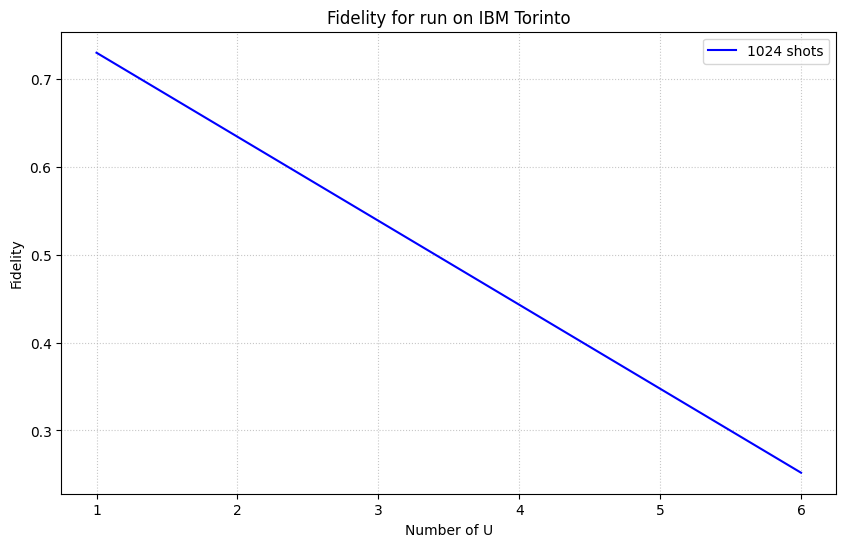

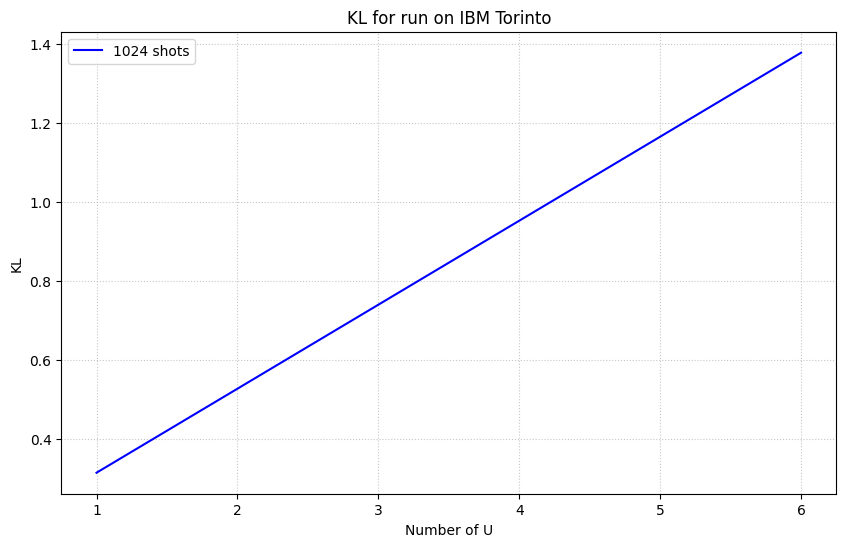

In [33]:
display_results(test_results)